In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from naca4digit_airfoil import Naca4DigitAirfoil
# from navier_stokes_with_data import NavierStokesPDEs
from navier_stokes import NavierStokesPDEs
import utils
import pandas as pd
from scipy.interpolate import griddata

/Users/ggito/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
cfd_df = pd.read_csv('NACA2412.txt', delimiter=',')

In [3]:
# x_min = -5
# x_max = 15
# y_min = -5
# y_max = 5

x_min = -0.25
x_max = 0.75
y_min = -0.25
y_max = 0.25

In [4]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')
dde.config.set_parallel_scaling('strong')

Set the default float type to float64


In [5]:
rho  = 1.225
# mu   = 1.789e-5
mu   = 0.0002
# u_in  = 15
u_inlet  = 0.75
L = 0.05

Re = rho * u_inlet * L / mu

In [6]:
rho, mu, u_inlet, L, Re

(1.225, 0.002, 0.75, 0.05, 22.968750000000004)

In [7]:
airfoil = Naca4DigitAirfoil(c=L, M=2, P=4, T=12, a=0, offset_x=0, offset_y=0)

In [8]:
# Geometry defintion
farfield = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

inner_rec  = dde.geometry.Rectangle([-0.5/20, -0.5/20], [0.5/20, 0.5/20])
inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)

mid_rec  = dde.geometry.Rectangle([-2.5/20, -1/20], [5/20, 1/20])
mid_dom  = dde.geometry.CSGDifference(mid_rec, inner_rec)
mid_dom  = dde.geometry.CSGDifference(mid_dom, airfoil_geom)

outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, mid_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)

In [9]:
Nf1 = 2**14 # = 16384
Nf2 = 2**14 # = 16384
Nf3 = 2**16 # = 65536
Nb  = 2**11 # = 2048
Ns  = 250

random = "Sobol"
inner_points = inner_dom.random_points(Nf1, random=random)
mid_points = mid_dom.random_points(Nf2, random=random)
outer_points = outer_dom.random_points(Nf3, random=random)

farfield_points = farfield.random_boundary_points(Nb, random=random)
airfoil_points  = airfoil.get_boundary_points(Ns)

# points = np.append(inner_points, mid_points, axis = 0)
# points = np.append(points, outer_points, axis = 0)
# points = np.append(points, airfoil_points, axis = 0)
# points = np.append(points, farfield_points, axis = 0)

static_points = np.append(inner_points, mid_points, axis = 0)
static_points = np.append(static_points, airfoil_points, axis = 0)
static_points = np.append(static_points, farfield_points, axis = 0)


/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+16385=16385. 
  warnings.warn("The balance properties of Sobol' points require "
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+65537=65537. 
  warnings.warn("The balance properties of Sobol' points require "
/Users/ggito/Library/Python/3.9/lib/python/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2051=2051. 
  warnings.warn("The balance properties of Sobol' points require "


(-0.35, 0.35)

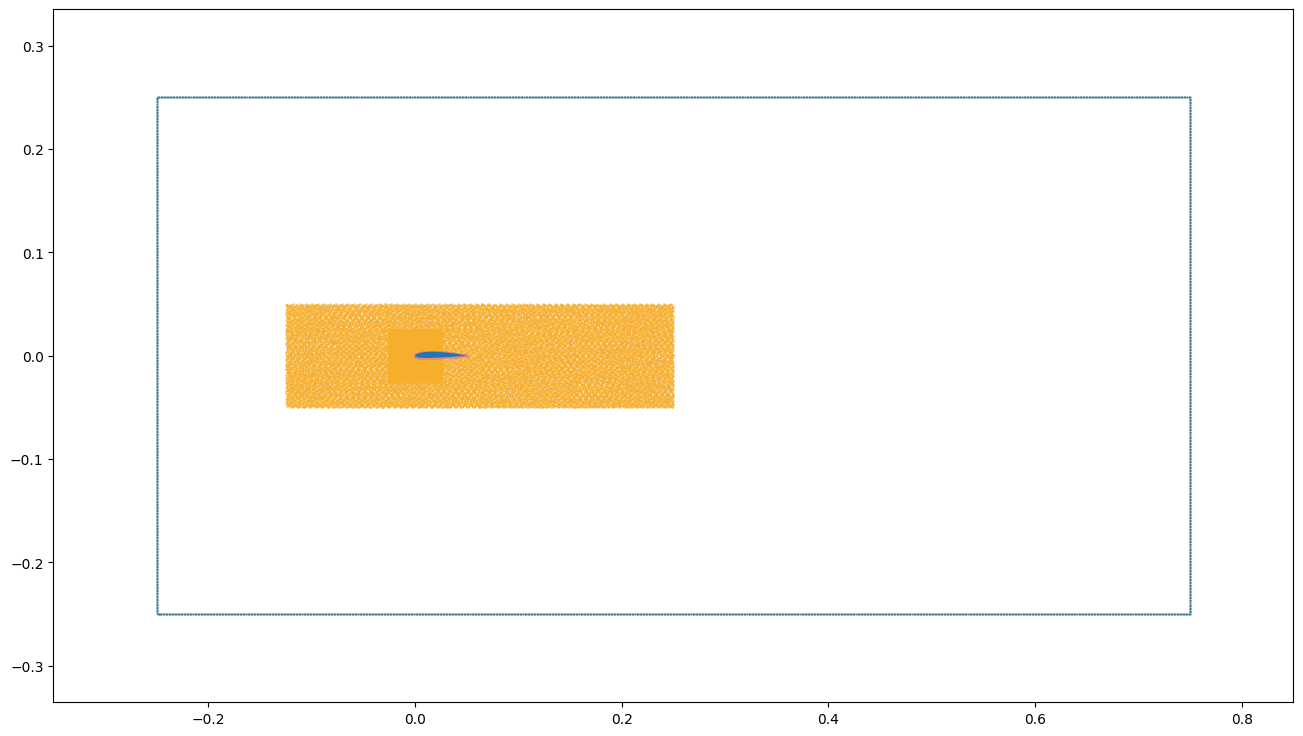

In [10]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.3, c='#40798C')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.3, c = '#F6AE2D')
plt.scatter(mid_points[:, 0], mid_points[:, 1], s = 0.3, c = '#F6AE2D')
# plt.scatter(outer_points[:, 0], outer_points[:, 1], s = 0.5, c = '#F6AE2D')
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.3, c = '#E9897E')
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([x_min - 0.1, x_max + 0.1])
plt.ylim([y_min - 0.1, y_max + 0.1])

In [11]:
# X, Y = np.meshgrid(np.linspace(cfd_df['x'].min(), cfd_df['x'].max(), 1000),
#                              np.linspace(cfd_df['y'].min(), cfd_df['y'].max(), 1000))

# U = griddata((cfd_df['x'], cfd_df['y']), cfd_df['u'], (X, Y), method='linear')

# fig, ax = plt.subplots(figsize=(10, 6))

# clev = np.arange(U.min(), U.max(), 0.01)
# cp = ax.contourf(X, Y, U, clev, cmap='jet')
# fig.colorbar(cp, ax=ax)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_title('Velocity Field - X Component')
# airfoil.plot(ax)
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# plt.show()

In [12]:
# V = griddata((cfd_df['x'], cfd_df['y']), cfd_df['v'], (X, Y), method='linear')

# fig, ax = plt.subplots(figsize=(10, 6))

# clev = np.arange(V.min(), V.max(), 0.01)
# cp = ax.contourf(X, Y, V, clev, cmap='jet')
# fig.colorbar(cp, ax=ax)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_title('Velocity Field - Y Component')
# airfoil.plot(ax)
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# plt.show()

In [13]:
# P = griddata((cfd_df['x'], cfd_df['y']), cfd_df['p'], (X, Y), method='linear')

# fig, ax = plt.subplots(figsize=(10, 6))

# clev = np.arange(P.min(), P.max(), 1)
# cp = ax.contourf(X, Y, P, clev, cmap='jet')
# fig.colorbar(cp, ax=ax)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_title('Pressure Field')
# airfoil.plot(ax)
# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# plt.show()

In [14]:
# x_data = farfield_points[:, 0]
# y_data = farfield_points[:, 1]

# grid_points = cfd_df[['x', 'y']].values
# u_values = cfd_df['u'].values / sf_uv
# v_values = cfd_df['v'].values / sf_uv
# p_values = cfd_df['p'].values

# u_interp = griddata(grid_points, u_values, (x_data, y_data), method='linear')
# v_interp = griddata(grid_points, v_values, (x_data, y_data), method='linear')
# p_interp = griddata(grid_points, p_values, (x_data, y_data), method='linear')

# uvp_data = np.vstack((u_interp, v_interp, p_interp)).T
# # uv_data = np.vstack((u_interp, v_interp)).T

# u_data = np.array([uvp_data[i][0] for i in range(len(uvp_data))])
# v_data = np.array([uvp_data[i][1] for i in range(len(uvp_data))])
# p_data = np.array([uvp_data[i][2] for i in range(len(uvp_data))])

# # u_data = np.array([uv_data[i][0] for i in range(len(uv_data))])
# # v_data = np.array([uv_data[i][1] for i in range(len(uv_data))])

In [15]:
# fig1, ax1 = plt.subplots(figsize = (16, 9))
# plt.axis('equal')
# scatter = plt.scatter(x_data, y_data, c=u_data, s=0.5, cmap='jet')
# plt.colorbar(scatter)
# plt.title('Velocity Field - X Component')
# plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
# plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
# plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
# plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])
# plt.show()

In [16]:
# fig1, ax1 = plt.subplots(figsize = (16, 9))
# plt.axis('equal')
# scatter = plt.scatter(x_data, y_data, c=v_data, s=0.5, cmap='jet')
# plt.colorbar(scatter)
# plt.title('Velocity Field - Y Component')
# plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
# plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
# plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
# plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])
# plt.show()

In [17]:
# fig1, ax1 = plt.subplots(figsize = (16, 9))
# plt.axis('equal')
# scatter = plt.scatter(x_data, y_data, c=p_data, s=0.5, cmap='jet')
# plt.colorbar(scatter)
# plt.title('Pressure Field')
# plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
# plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
# plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
# plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])
# plt.show()

In [18]:
navier_stokes_pdes = NavierStokesPDEs(rho=rho, mu=mu,
                                      xmin=x_min, xmax=x_max, ymin=y_min, ymax=y_max,
                                      airfoil_geom=airfoil_geom, geom=geom,
                                      u_inlet=u_inlet, v_farfield=0)

pdes_fun = navier_stokes_pdes.get_pdes
bcs = navier_stokes_pdes.get_bcs()

In [19]:
# Problem setup
data = dde.data.PDE(geom, pdes_fun, bcs, num_domain = Nf3, num_boundary = 0, num_test = 1000, anchors = static_points, train_distribution = "Hammersley")

(-0.3, 0.8, -0.275, 0.275)

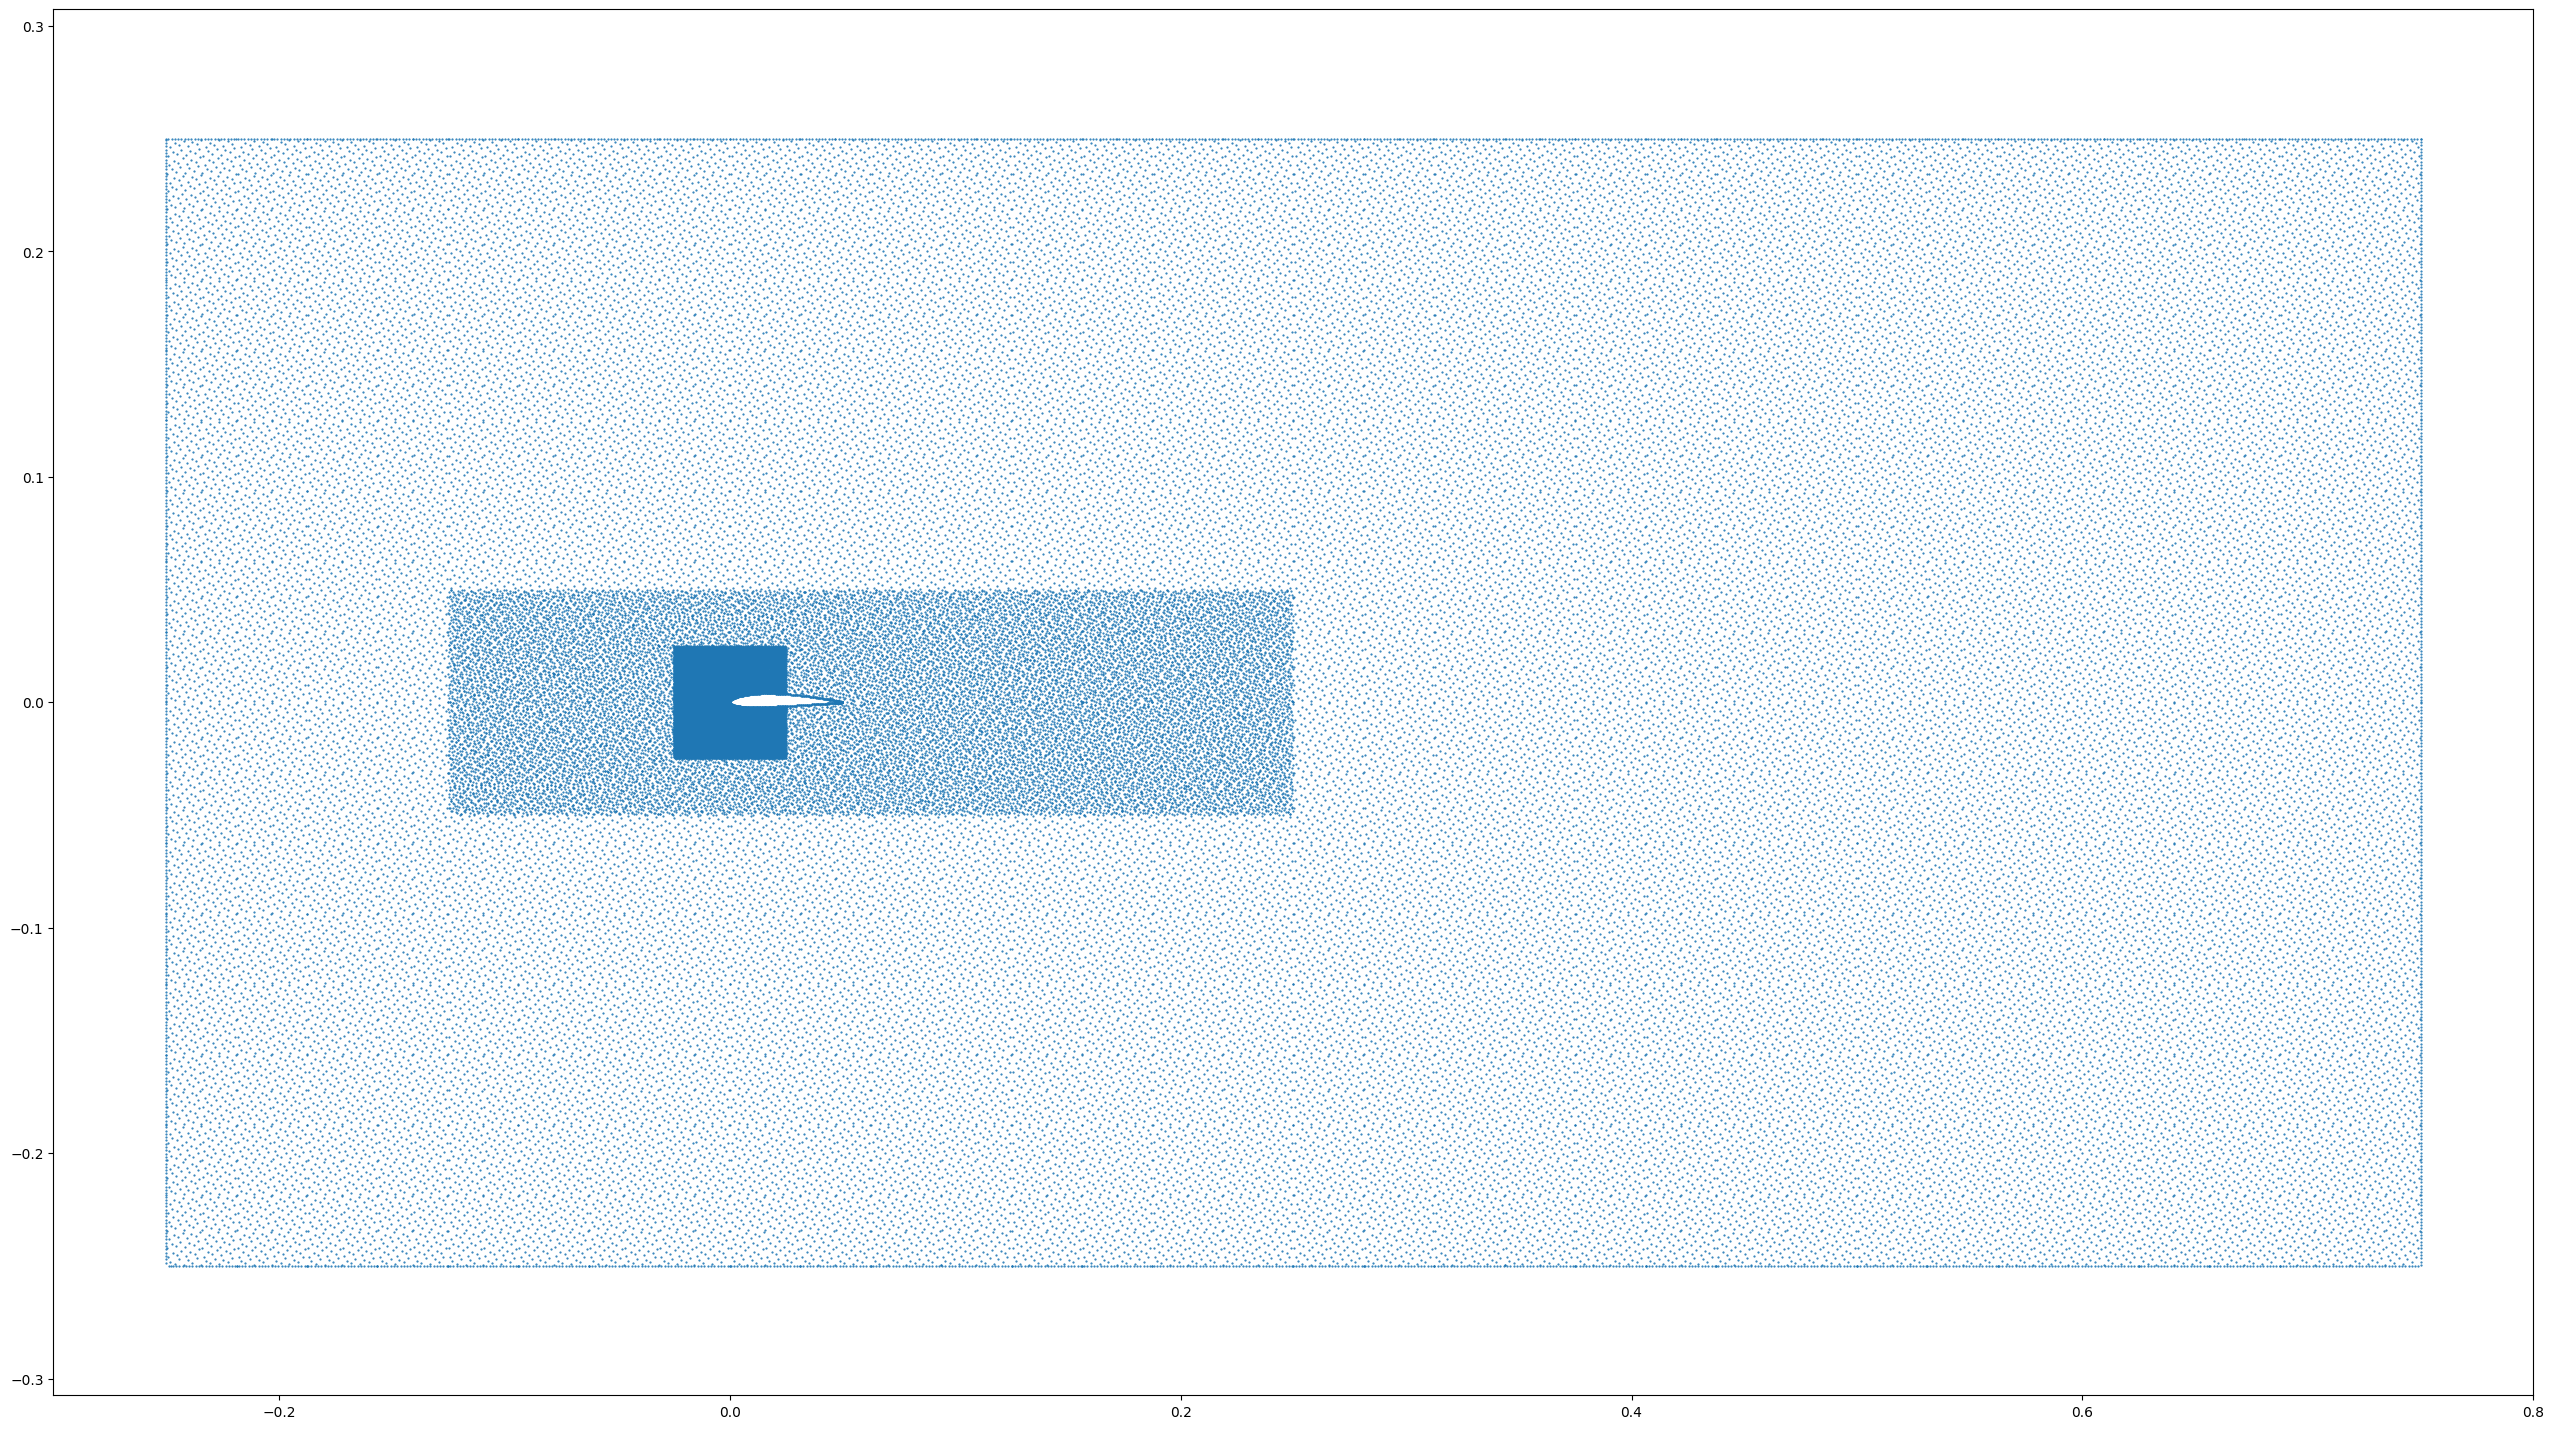

In [20]:
plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

In [21]:
# Neural network definition
# layer_size  = [2] + [32] * 10 + [3]
layer_size  = [2] + [50] * 10 + [5]
activation  = 'tanh'
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)

In [22]:
name_generator = utils.NameGenerator()
model_name = name_generator.generate_name()
model_name

'GustAnalyticNebula561'

In [23]:
# model.compile(optimizer = 'adam', lr = 5e-4, loss_weights=[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
model.compile(optimizer = 'adam', lr = 5e-4, loss_weights=[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])
# model.compile(optimizer = 'adam', lr = 1e-3, loss_weights=[1, 1, 2, 2, 2, 2, 2])

Compiling model...
'compile' took 0.013933 s



In [28]:
resampler = dde.callbacks.PDEPointResampler(period = 100, pde_points=True, bc_points=False)

In [32]:
try:
  losshistory, train_state = model.train(epochs = 1000, display_every = 50, callbacks=[resampler], model_save_path = './' + model_name + '/')
  dde.saveplot(losshistory, train_state, issave = True, isplot = True)

except KeyboardInterrupt:
  print(f"Training stopped by user.")
  print("=======================================================")

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
2000      [2.88e-03, 7.39e-04, 1.71e-04, 1.47e-04, 7.57e-04, 3.41e-05, 1.87e-03, 2.72e-03, 2.97e-04, 1.73e-03, 4.30e-04]    [2.32e-03, 9.03e-04, 2.01e-04, 1.65e-04, 6.74e-04, 4.27e-05, 1.87e-03, 2.72e-03, 2.97e-04, 1.73e-03, 4.30e-04]    []  
2050      [5.17e-03, 7.57e-04, 1.76e-04, 1.50e-04, 7.53e-04, 3.52e-05, 1.45e-03, 2.76e-03, 3.50e-04, 3.95e-03, 4.49e-04]    [3.36e-03, 9.24e-04, 2.16e-04, 1.72e-04, 6.33e-04, 4.59e-05, 1.45e-03, 2.76e-03, 3.50e-04, 3.95e-03, 4.49e-04]    []  
2100      [5.67e-03, 7.59e-04, 1.97e-04, 1.52e-04, 7.39e-04, 3.75e-05, 1.46e-03, 2.82e-03, 3.18e-04, 7.78e-03, 1.20e-04]    [3.25e-03, 9.49e-04, 2.43e-04, 1.75e-04, 6.01e-04, 4.50e-05, 1.46e-03, 2.82e-03, 3.18e-04, 7.78e-03, 1.20e-04]    []  
21

In [ ]:
# model_name = 'AtmosElegantGalaxy375'
# model.restore('./out/AtmosElegantGalaxy375/-20000.ckpt.index')

In [33]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.025
dy = 0.025
x = np.arange(x_min, x_max + dy, dx)
y = np.arange(y_min, y_max + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

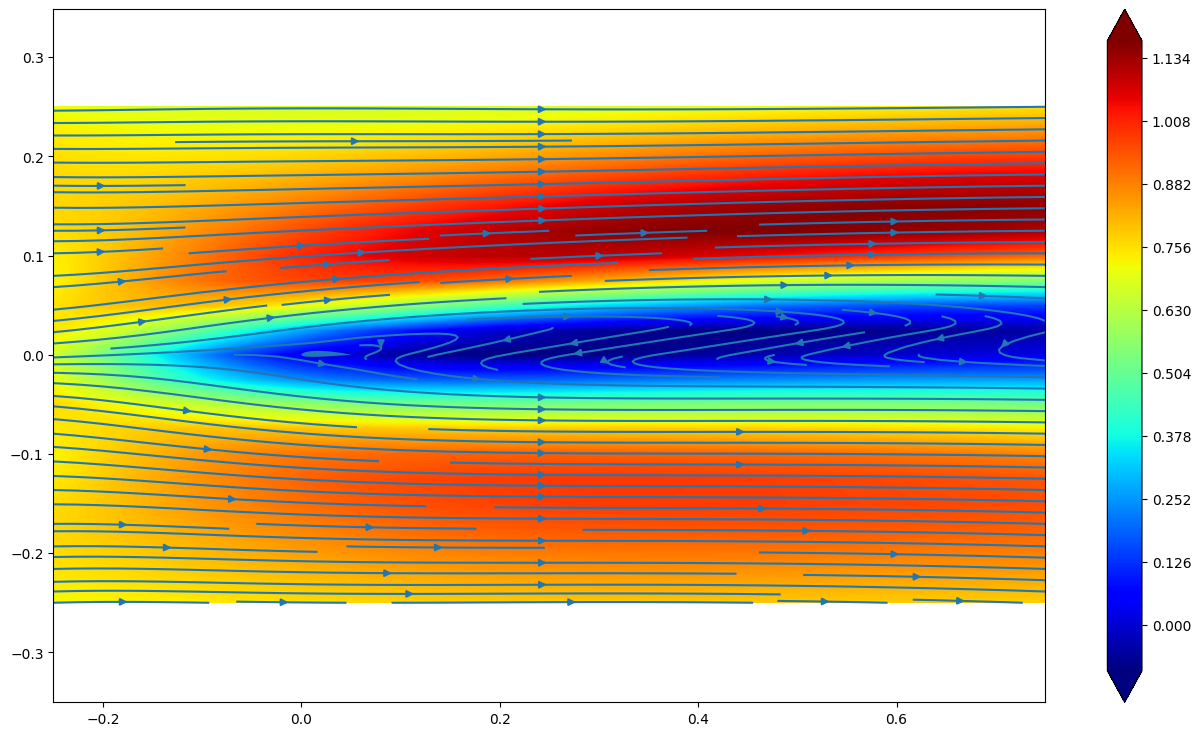

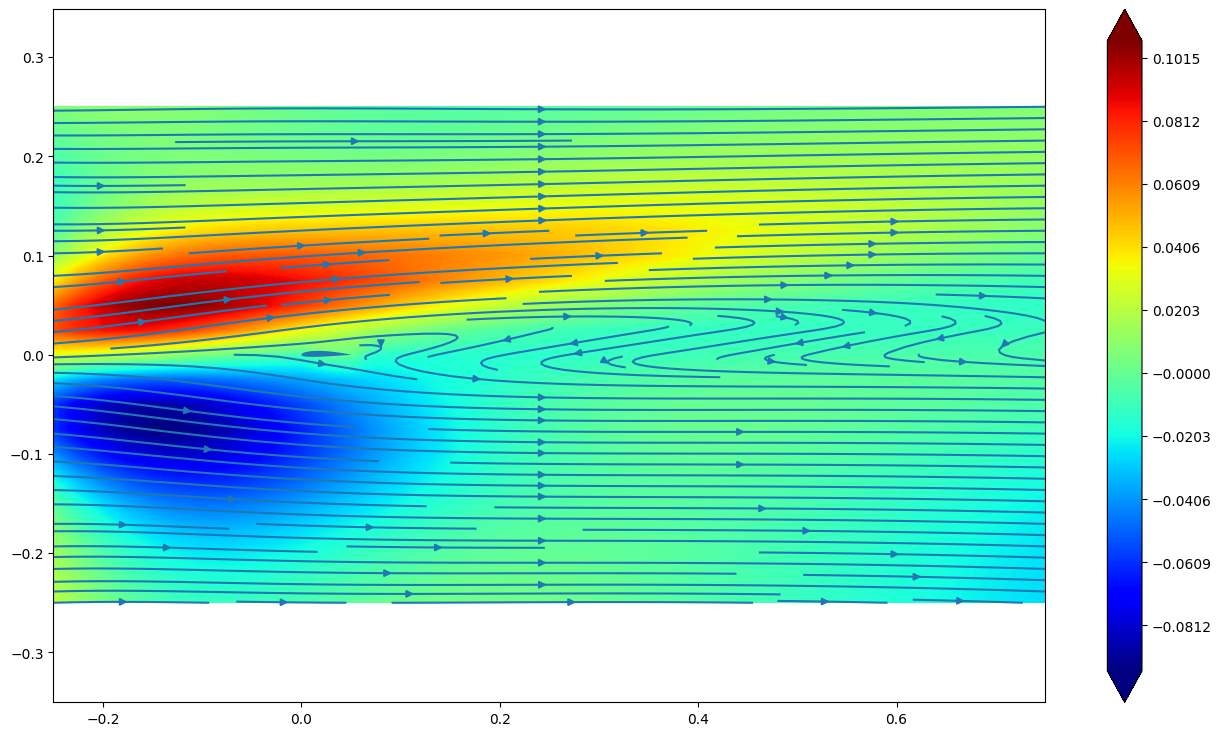

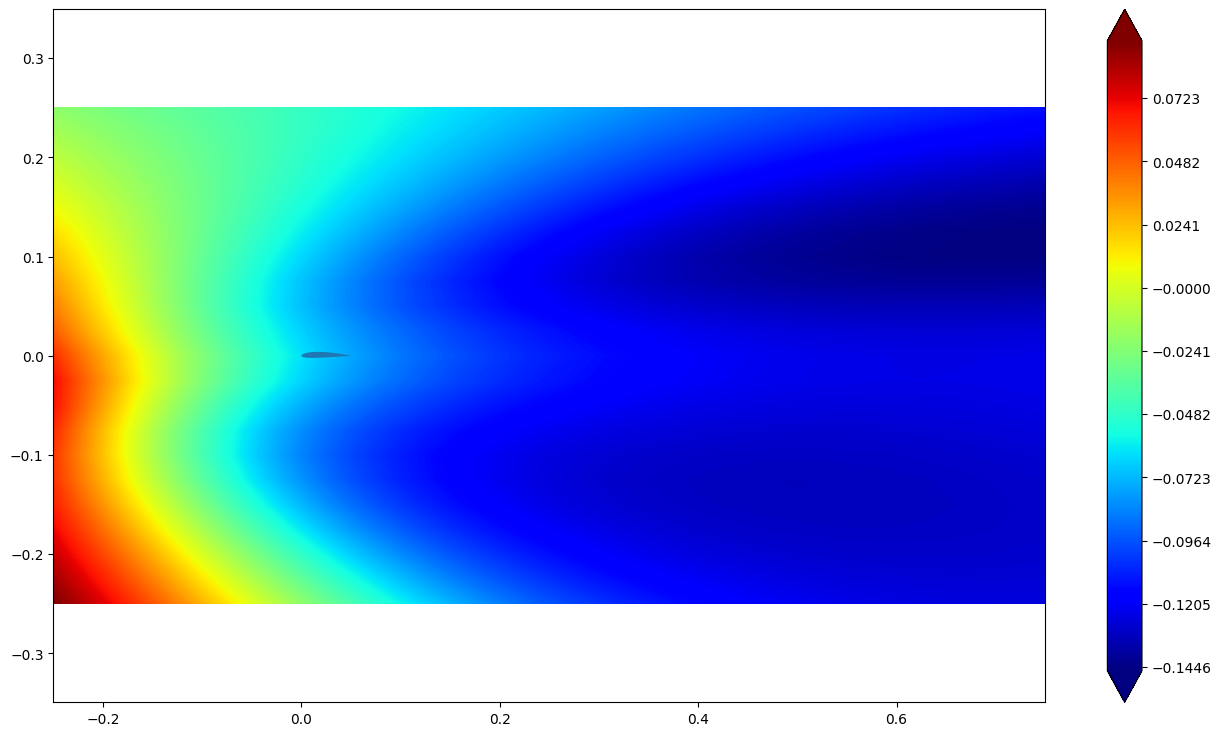

In [34]:
# Model predictions generation
u = model.predict(X, operator = navier_stokes_pdes.getU)
v = model.predict(X, operator = navier_stokes_pdes.getV)
p = model.predict(X, operator = navier_stokes_pdes.getP)

for i in range(len(X)):
   if airfoil_geom.inside(np.array([X[i]]))[0]:
       u[i] = 0.0
       v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

airfoil_plot = airfoil.get_boundary_points(150)

fig1, ax1 = plt.subplots(figsize = (16, 9))
ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(u.min(), u.max(), 0.001)
cnt1 = ax1.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig('./u.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
ax2.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(v.min(), v.max(), 0.00001)
cnt2 = ax2.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig('./v.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
clev = np.arange(p.min(), p.max(), 0.0001)
cnt3 = ax3.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig('./p.png')